# Stock Price Prediction using RNN (Recurrent Neural Network)

이 노트북은 AAME.csv 데이터를 활용하여 RNN으로 주가 예측 모델을 구현합니다.

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
import math

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

## 1. 데이터 로드 및 전처리

In [2]:
# GitHub에서 AAME.csv 데이터 가져오기
url = 'https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/AAME.csv'
df = pd.read_csv(url)

# 데이터 확인
print("데이터 형태:", df.shape)
df.head()

데이터 형태: (10098, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.0,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.0,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.0,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.0,3.95,3.75,3.75,3.129709,12700


C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51

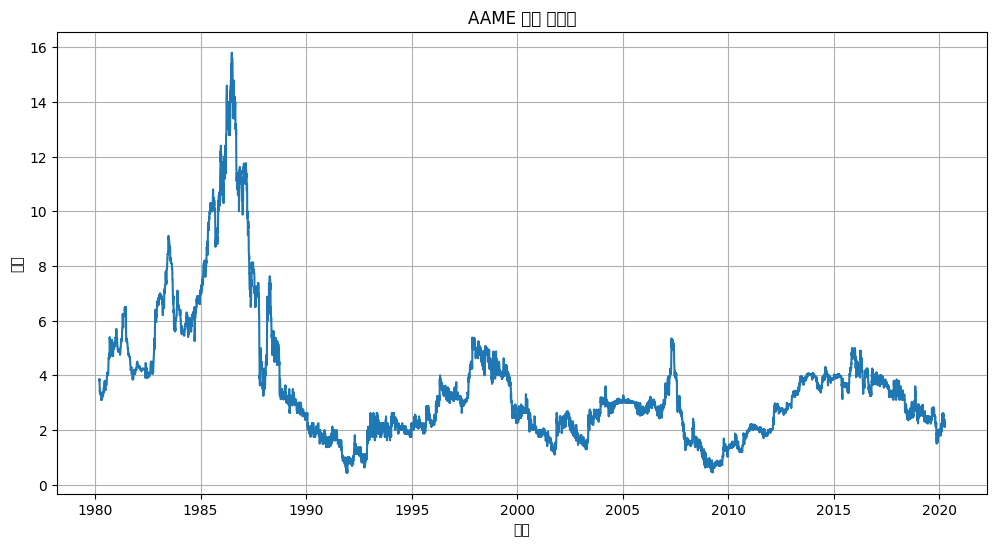

In [3]:
# 날짜 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 필요한 칼럼(Open, High, Low, Close)만 선택
data = df[['Open', 'High', 'Low', 'Close']]

# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('AAME 종가 데이터')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.grid(True)
plt.show()

In [4]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

print(f"학습 데이터 크기: {train_size}, 테스트 데이터 크기: {test_size}")

학습 데이터 크기: 8078, 테스트 데이터 크기: 2020


## 2. 시계열 데이터 준비 함수

In [5]:
def create_dataset(dataset, time_step=1):
    """
    시계열 데이터를 입력과 출력 쌍으로 변환하는 함수
    time_step: 예측에 사용할 이전 데이터 포인트의 수
    """
    X, y = [], []
    for i in range(len(dataset) - time_step):
        # 입력: time_step 기간 동안의 모든 특성(Open, High, Low, Close)
        a = dataset[i:(i + time_step), :]
        X.append(a)
        # 출력: 다음 날의 종가(Close)
        y.append(dataset[i + time_step, 3])  # 3은 Close 열의 인덱스
    return np.array(X), np.array(y)

In [6]:
# 시계열 데이터 생성 (최근 60일 데이터로 다음 날 종가 예측)
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(f"X_train 형태: {X_train.shape}, y_train 형태: {y_train.shape}")
print(f"X_test 형태: {X_test.shape}, y_test 형태: {y_test.shape}")

X_train 형태: (8018, 60, 4), y_train 형태: (8018,)
X_test 형태: (1960, 60, 4), y_test 형태: (1960,)


## 3. RNN 모델 구축

In [7]:
# RNN 모델 생성
model = Sequential()

# SimpleRNN 레이어 추가
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, 4)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # 출력층

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2750      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## 4. 모델 학습

In [8]:
# 모델 학습
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
201/201 [==============================] - 27s 82ms/step - loss: 0.1348 - val_loss: 0.0036
Epoch 2/50
201/201 [==============================] - 16s 77ms/step - loss: 0.0270 - val_loss: 3.1398e-04
Epoch 3/50
201/201 [==============================] - 14s 71ms/step - loss: 0.0135 - val_loss: 8.7771e-05
Epoch 4/50
201/201 [==============================] - 13s 66ms/step - loss: 0.0083 - val_loss: 1.0860e-04
Epoch 5/50
201/201 [==============================] - 15s 75ms/step - loss: 0.0054 - val_loss: 6.9891e-05
Epoch 6/50
201/201 [==============================] - 14s 68ms/step - loss: 0.0043 - val_loss: 6.8503e-05
Epoch 7/50
201/201 [==============================] - 14s 68ms/step - loss: 0.0035 - val_loss: 9.1403e-05
Epoch 8/50
201/201 [==============================] - 15s 77ms/step - loss: 0.0028 - val_loss: 7.0663e-05
Epoch 9/50
201/201 [==============================] - 15s 74ms/step - loss: 0.0024 - val_loss: 9.6966e-05
Epoch 10/50
201/201 [=============================

C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 495

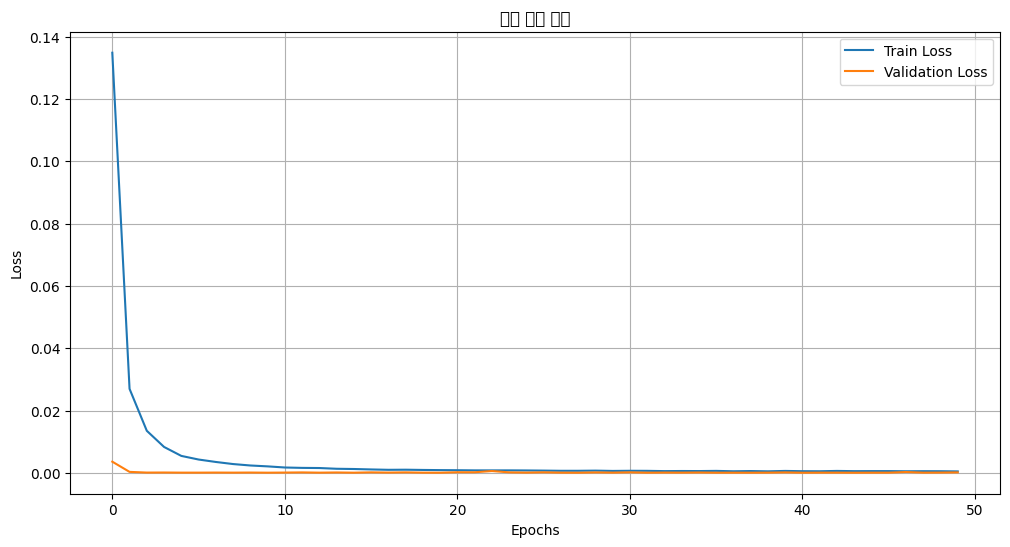

In [9]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 학습 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. 모델 평가 및 예측

In [10]:
# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 예측값 역정규화
# 원래 스케일로 되돌리기 위해 원본 형태의 배열 생성
pred_shape = np.zeros((len(y_pred), 4))
test_shape = np.zeros((len(y_test), 4))

# Close 값만 채움 (다른 값은 0으로 유지)
pred_shape[:, 3] = y_pred.flatten()
test_shape[:, 3] = y_test

# 역정규화
y_pred_actual = scaler.inverse_transform(pred_shape)[:, 3]
y_test_actual = scaler.inverse_transform(test_shape)[:, 3]

62/62 [==============================] - 3s 24ms/step


In [11]:
# 성능 평가
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = math.sqrt(mse)
print(f'평균 제곱 오차(MSE): {mse}')
print(f'평균 제곱근 오차(RMSE): {rmse}')

평균 제곱 오차(MSE): 0.02559426175752908
평균 제곱근 오차(RMSE): 0.15998206698730041


C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 

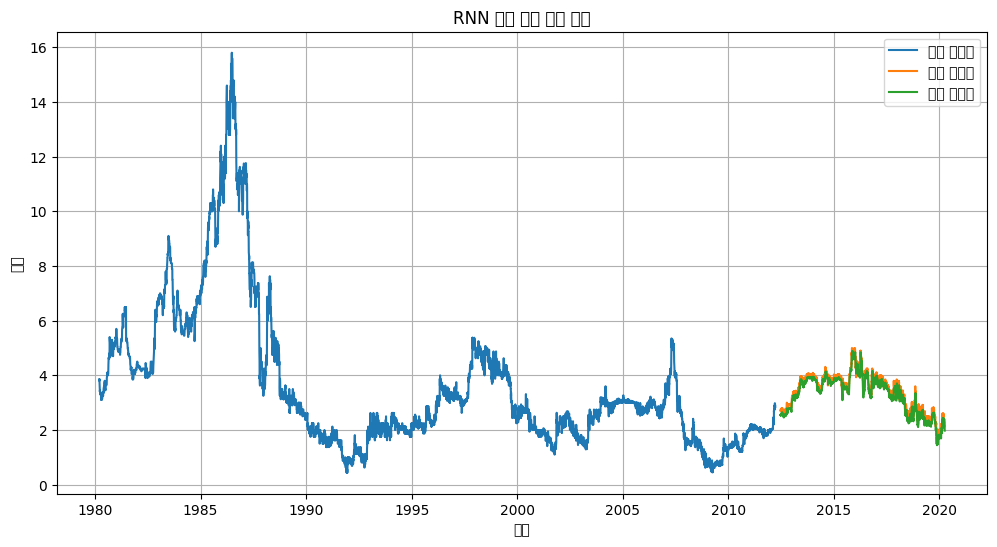

In [12]:
# 결과 시각화
train_dates = df.index[:train_size]
test_dates = df.index[train_size + time_step:train_size + time_step + len(y_test_actual)]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, df['Close'].values[:train_size], label='학습 데이터')
plt.plot(test_dates, y_test_actual, label='실제 데이터')
plt.plot(test_dates, y_pred_actual, label='예측 데이터')
plt.title('RNN 모델 주가 예측 결과')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.grid(True)
plt.show()

## 6. 미래 예측

In [13]:
# 마지막 time_step 기간의 데이터로 다음 날 종가 예측
last_data = scaled_data[-time_step:]
last_data_reshaped = np.reshape(last_data, (1, time_step, 4))

# 다음 날 종가 예측
next_day_pred = model.predict(last_data_reshaped)

# 예측값 역정규화
pred_shape = np.zeros((1, 4))
pred_shape[0, 3] = next_day_pred[0, 0]
next_day_pred_actual = scaler.inverse_transform(pred_shape)[0, 3]

print(f"다음 거래일 예상 종가: ${next_day_pred_actual:.2f}")

1/1 [==============================] - 0s 133ms/step
다음 거래일 예상 종가: $1.96
